In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
%matplotlib inline

In [21]:
country = str(input("Enter Country(US, Egypt... etc):"))

df_confirmed = pd.read_csv('/content/drive/MyDrive/Projects/convid/time_series_covid19_confirmed_global.csv')

Enter Country(US, Egypt... etc):US


In [22]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,155466,155508,155540,155599,155627,155682,155688,155739,155764,155776,155801,155859,155891,155931,155940,155944,156040,156071,156124,156166,156196,156210,156250,156284,156307,156323,156363,156392,156397,156397,156397,156397,156414,156456,156487,156510,156552,156610,156649,156739
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,174643,174968,175163,175664,176172,176667,177108,177536,177971,178188,178804,179463,180029,180623,181252,181696,181960,182610,183282,183873,184340,184887,185300,185497,186222,186793,187363,187994,187994,189125,189355,190125,190815,191440,192013,192600,193075,193269,193856,194472
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,204490,204597,204695,204790,204900,205005,205106,205199,205286,205364,205453,205529,205599,205683,205750,205822,205903,205990,206069,206160,206270,206358,206452,206566,206649,206754,206878,206995,207079,207156,207254,207385,207509,207624,207764,207873,207970,208104,208245,208380
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15291,15291,15307,15307,15314,15326,15338,15338,15338,15367,15369,15382,15382,15404,15404,15404,15425,15425,15462,15505,15516,15516,15516,15516,15516,15572,15618,15618,15618,15618,15705,15717,15744,15744,15819,15819,15819,15907,15929,15972
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,61245,61378,61580,61794,62143,62385,62606,62789,62842,63012,63197,63340,63567,63691,63775,63861,63930,64033,64126,64226,64301,64374,64433,64458,64487,64533,64583,64612,64654,64674,64724,64762,64815,64857,64875,64899,64913,64913,64940,64968


In [23]:
df_confirmed_country = df_confirmed[df_confirmed['Country/Region'] == country]
columns  = df_confirmed_country.columns[4:]
len(columns)

666

In [24]:
index = df_confirmed_country.columns[4:]
values = list(df_confirmed_country[df_confirmed_country.columns[4:]].sum())
df = pd.DataFrame(index=index, data=values, columns=['Confirmed'])
del index, values
df.index = pd.to_datetime(df.index, format='%m/%d/%y')

In [25]:
df.tail()

,Confirmed
2021-11-13,47054618
2021-11-14,47079428
2021-11-15,47221527
2021-11-16,47309008
2021-11-17,47420114


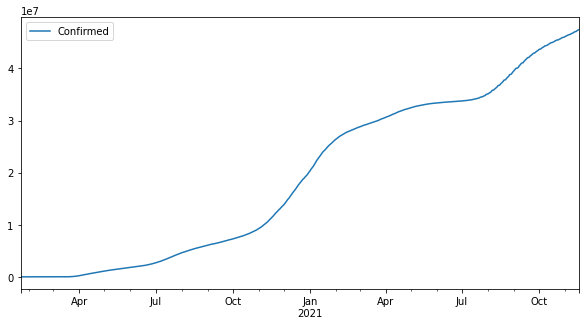

In [26]:
df.plot(figsize=(10, 5), )
plt.show()

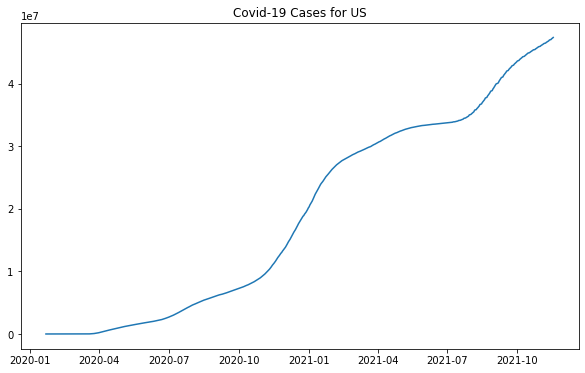

In [27]:
plt.figure(figsize=(10 , 6))
plt.plot(df.Confirmed)
plt.title(f'Covid-19 Cases for {country}')
plt.show()

### Use the dataset for training and the last tow weeks for testing. 

In [28]:
size = 14 
train = df[:-size]
test = df[-size:]

In [29]:
print(f'Traning size: {len(train)} days\nTesting size: {len(test)} days')

Traning size: 652 days
Testing size: 14 days


### Scalling 

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)


### Bulding the sequance for traning usning TimeseriesGenerator

In [31]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seq_size = 7
n_features = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=seq_size, batch_size=1)

print(f'Total number of samples in the origina traning data = {len(train)}')
print(f'Total number of samples in the traning data = {len(train_generator)}')

Total number of samples in the origina traning data = 652
Total number of samples in the traning data = 645


In [32]:
print(f"Cheking the shape of the X and y of our Data {train_generator[10]}")
# the output is right, we have 7 days and the 8ths is the label 

Cheking the shape of the X and y of our Data (array([[[1.51258640e-07],
        [1.51258640e-07],
        [2.16083772e-07],
        [2.16083772e-07],
        [2.16083772e-07],
        [2.37692149e-07],
        [2.37692149e-07]]]), array([[2.37692149e-07]]))


### Bulding the sequance for Testing usning TimeseriesGenerator

In [33]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)

print(f'Total number of samples in the origina traning data = {len(test_scaled)}')
print(f'Total number of samples in the traning data = {len(train_generator)}')

Total number of samples in the origina traning data = 14
Total number of samples in the traning data = 645


In [34]:
print(f"Cheking the shape of the X and y of our Data {test_generator[1]}")
# the output is right, we have 7 days and the 8ths is the label 

Cheking the shape of the X and y of our Data (array([[[1.00384391],
        [1.00455379],
        [1.00531564],
        [1.00774274],
        [1.00947225],
        [1.01151848],
        [1.01271372]]]), array([[1.01574754]]))


### Building the model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation


model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 128)            66560     
                                                                 
 lstm_4 (LSTM)               (None, 7, 128)            131584    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 251,777
Trainable params: 251,777
Non-trainable params: 0
_________________________________________________________________


In [36]:

history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, steps_per_epoch=10)



Epoch 1/50
10/10 [==============================] - 4s 81ms/step - loss: 0.2918 - mse: 0.2918 - val_loss: 0.8081 - val_mse: 0.8081
Epoch 2/50
10/10 [==============================] - 0s 21ms/step - loss: 0.1285 - mse: 0.1285 - val_loss: 0.2096 - val_mse: 0.2096
Epoch 3/50
10/10 [==============================] - 0s 20ms/step - loss: 0.1141 - mse: 0.1141 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 4/50
10/10 [==============================] - 0s 20ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.1821 - val_mse: 0.1821
Epoch 5/50
10/10 [==============================] - 0s 21ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 6/50
10/10 [==============================] - 0s 21ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 7/50
10/10 [==============================] - 0s 20ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 8/50
10/10 [==============================] - 0s 22ms/step - loss: 0.0052 - m

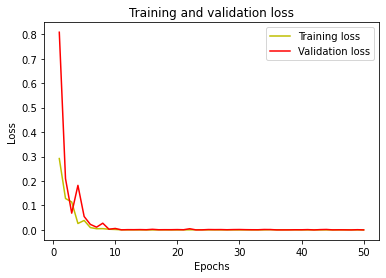

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Prediction

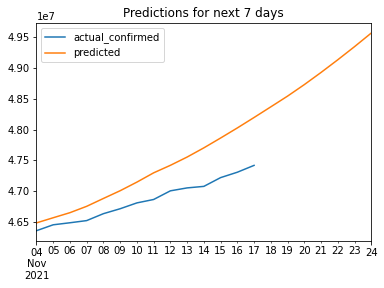

In [38]:

#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["Confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")

 
    